# sparse coding of images

In [1]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from sklearn.decomposition import dict_learning_online
from sklearn.decomposition import sparse_encode
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from skimage.transform import resize

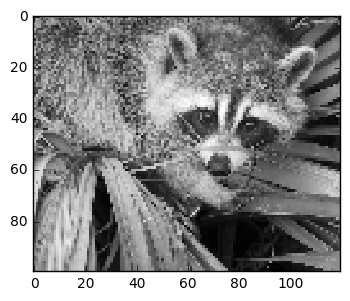

Extracting patches from the left half...
done in 0.02s.
(3956, 225)


In [2]:
try:
    from scipy import misc
    face = misc.face(gray=True)
except AttributeError:
    # Old versions of scipy have face in the top level package
    face = sp.face(gray=True)
    
face = resize(face, (100,120))
height, width = face.shape
plt.figure(figsize=(5, 3.3))
plt.imshow(face, cmap=plt.cm.gray, interpolation='nearest')
plt.show()

# 0~255 => 0~1
face = face / 255.0
# Extract all reference patches from the left half of the image
print('Extracting patches from the left half...')
t0 = time()
patch_size = (15, 15)
data = extract_patches_2d(face[:, :width // 2], patch_size)
data = data.reshape(data.shape[0], -1)
print('done in %.2fs.' % (time() - t0))
print data.shape
np.savetxt('patches_{}_{}'.format(data.shape[1], data.shape[0]), data, delimiter=' ', fmt='%.5f')

In [7]:
K = 500
print('Learning the dictionary...')
t0 = time()
_, V = dict_learning_online(data, n_components=K, alpha=1, n_iter=500, dict_init=None, batch_size=1, shuffle=False, method='lars', inner_stats=None)
print('done in %.2fs.' % (time() - t0))

plt.figure(figsize=(15, 6))
for i, comp in enumerate(V[:K]):
    plt.subplot(5, 20, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
plt.show()

Learning the dictionary...
done in 51.06s.


ValueError: num must be 1 <= num <= 100, not 101

# with and without constant atom

In [ ]:
print('Extracting unseen patches on the right half... ')
t0 = time()
data = extract_patches_2d(face[:, width // 2:], patch_size)
data = data.reshape(data.shape[0], -1)
print('done in %.2fs.' % (time() - t0))
new_V = np.concatenate((V, np.ones((1,V.shape[1]))), axis=0)

plt.figure(figsize=(10, 3.3))
plt.subplot(1, 2, 1)
print('Encoding and decoding unseen patches of the right half with constant atom... ')
t0 = time()
code = sparse_encode(data, new_V, algorithm='lars', alpha=0.5)
print('done in %.2fs.' % (time() - t0))
patches = np.dot(code, new_V)
patches = patches.reshape(len(data), *patch_size)
reconstruction = face.copy()
reconstruction[:, width // 2:] = reconstruct_from_patches_2d(patches, (height, width // 2))
plt.imshow(reconstruction, cmap=plt.cm.gray, interpolation='nearest')
plt.title("with constant atom", size=16)

plt.subplot(1, 2, 2)
print('Encoding and decoding unseen patches of the right half without constant atom... ')
t0 = time()
code = sparse_encode(data, V, algorithm='lars', alpha=0.5)
print('done in %.2fs.' % (time() - t0))
patches = np.dot(code, V)
patches = patches.reshape(len(data), *patch_size)
reconstruction2 = face.copy()
reconstruction2[:, width // 2:] = reconstruct_from_patches_2d(patches, (height, width // 2))
plt.imshow(reconstruction2, cmap=plt.cm.gray, interpolation='nearest')
plt.title("without constant atom", size=16)

plt.show()

# Our DL

### Run cpp first

In [ ]:
import pandas as pd
my_D = pd.read_csv('dictionary_{}_{}'.format(data.shape[1], K), delim_whitespace=True, header=None).as_matrix()
print my_D.shape

In [ ]:
plt.figure(figsize=(15, 6))
for i, comp in enumerate(my_D[:K]):
    plt.subplot(5, 20, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
plt.show()

In [ ]:
print('Extracting unseen patches on the right half... ')
t0 = time()
data = extract_patches_2d(face[:, width // 2:], patch_size)
data = data.reshape(data.shape[0], -1)
print('done in %.2fs.' % (time() - t0))
new_D = np.concatenate((my_D, np.ones((1,V.shape[1]))), axis=0)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
print('Encoding and decoding unseen patches of the right half with constant atom... ')
print(new_D.shape)
t0 = time()
code = sparse_encode(data, new_D, algorithm='lars', alpha=0.5)
print('done in %.2fs.' % (time() - t0))
patches = np.dot(code, new_D)
patches = patches.reshape(len(data), *patch_size)
reconstruction = face.copy()
reconstruction[:, width // 2:] = reconstruct_from_patches_2d(patches, (height, width // 2))
plt.imshow(reconstruction, cmap=plt.cm.gray, interpolation='nearest')
plt.title("with constant atom", size=16)
plt.xticks(())
plt.yticks(())

plt.subplot(1, 3, 2)
print('Encoding and decoding unseen patches of the right half without constant atom... ')
t0 = time()
code = sparse_encode(data, my_D, algorithm='lars', alpha=0.5)
print('done in %.2fs.' % (time() - t0))
patches = np.dot(code, my_D)
patches = patches.reshape(len(data), *patch_size)
reconstruction2 = face.copy()
reconstruction2[:, width // 2:] = reconstruct_from_patches_2d(patches, (height, width // 2))
plt.imshow(reconstruction2, cmap=plt.cm.gray, interpolation='nearest')
plt.title("without constant atom", size=16)
plt.xticks(())
plt.yticks(())

plt.subplot(1, 3, 3)
print('Encoding and decoding unseen patches of the right half with random dictionary... ')
t0 = time()
random_dict = np.random.randn(my_D.shape[0], my_D.shape[1])
code = sparse_encode(data, random_dict, algorithm='lars', alpha=0.5)
print('done in %.2fs.' % (time() - t0))
patches = np.dot(code, random_dict)
patches = patches.reshape(len(data), *patch_size)
reconstruction2 = face.copy()
reconstruction2[:, width // 2:] = reconstruct_from_patches_2d(patches, (height, width // 2))
plt.imshow(reconstruction2, cmap=plt.cm.gray, interpolation='nearest')
plt.title("without random dictionary", size=16)
plt.xticks(())
plt.yticks(())

plt.show()